<a href="https://colab.research.google.com/github/xiutingc/GASP-python/blob/master/ml_intro_healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to AI & ML**
### *Michaela Buchanan - Mark III Systems*




---

If you would like to see another example using these algorithms, there is a second version of this notebook available here: https://colab.research.google.com/drive/1-7g2CRQinW_ytjZvJbOd74vnqu4OAdoL?usp=sharing 

It covers the same algorithms but uses a car information dataset to try to predict car prices using regression rather than the tumor classification found in this notebook. 



Imports for all the code below. Please run first before anything else!

In [ ]:
!git clone https://github.com/michaelabuchanan/ml_workshop.git

# data preprocessing
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# logistic regression
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBClassifier



---

###Introduction


This workshop will be showing both the workflow of a typical ML project as well as demonstrating a few common models. We will be following the ML Project lifecycle mentioned in the previous lecture and covering linear regression, decision trees, random forest, and XGBoost models.

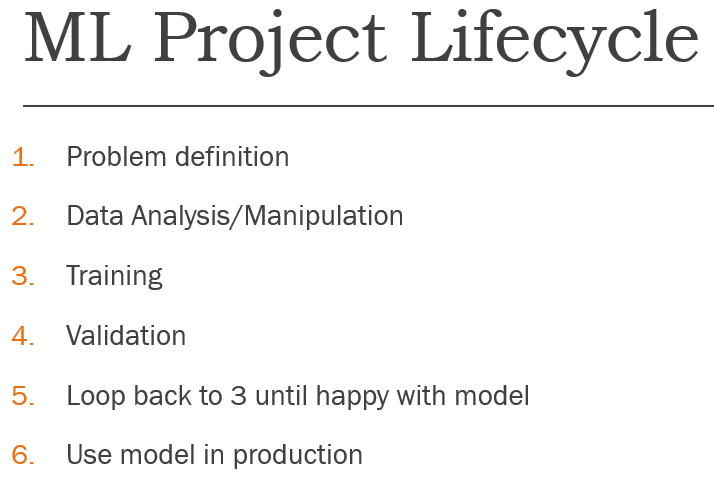


---

###Problem Definition


Classify breast tumors as malignant or benign based on features such as radius, texture, smoothness, etc



---

### Data Analysis/Preprocessing


The first step we need to take is to look at our data. In the first cell you ran, you cloned a GitHub repo which contained the `breast-cancer.csv` file. A few rows of this file are shown below.

In [ ]:
data = pd.read_csv('./ml_workshop/breast-cancer.csv')
data

First let's check out what datatypes we have in our dataset. If the data types are not what we expect, we could run into problems with our preprocessing and later on with our training.

In [ ]:
data.dtypes

In general, you can't provide text input to a ML model. As you can see above almost all of our columns are of type float64, which means they are decimal numbers and should be fine to feed into our model. However, the diagnosis column is represented by a M for malignant or a B for benign. We are going to have to encode this information numerically so that our model can use it. Luckily this is very easy as we can assign 0 to represent M and 1 to represent B.

One last thing to check before we train. If any of the values are missing in our dataset, they will be listed as NaN (not a number) in our dataframe. When we go to train, our algorithm won't know what to do with these values so we are going to go ahead and remove any rows with missing values now. We should also check for and remove any duplicated columns as well.

In [ ]:
data.dropna(inplace=True)
data = data.loc[:,~data.columns.duplicated()]
data

In this case it appears there weren't any duplicates or missing data rows based on the fact that we still have 569 rows after performing our cleaning. However it never hurts to check!



---

###Single Variable Logistic Regression

While we could spend much more time going through our data to make it easier to train off of, I'm going to move on to training using logistic regression due to time constraints for this session. Logistical regression is very similar to linear regression with the main difference being that we get a categorical output rather than a continious one. This is what we need to be able to classify into our `M` (malignant) and `B` (benign) categories. To make things simpler we will be starting off with just one variable to make our predictions which means we need to be able to choose the best category from our dataset to use. The code below creates a graph of the distribution of our two categories among data entries in different columns in our dataset. The columns we are testing are listed in the `test_columns` list. Feel free to change which columns are being used to see if you can find one that fits our task even better than the ones used below.

In [ ]:
test_columns = ["radius_mean", "area_mean", "symmetry_mean", "perimeter_mean"]

for feature_name in test_columns:
  plt.figure()
  data.groupby("diagnosis")[feature_name].plot.hist(alpha=0.5, density=True, legend=True)
  plt.xlabel(feature_name)

As you can tell from the graphs above, `symmetry_mean` would be a poor choice to use for our model as there is a lot of overlap between our two categories. A better choice might be `area_mean` which seems to have a smaller overlap. Let's run an example of our logistic regression model using both of these categories to see if our theory is correct. We will start with `symmetry_mean`.

In [ ]:
# feel free to play with different features to use for X, ie perimeter_mean, compactness_mean, etc
x_single = data['symmetry_mean']
y_single = data['diagnosis']

# some of this code comes from https://pythonspot.com/linear-regression/

x_single = x_single.values.reshape(len(x_single),1)
y_single = y_single.values.reshape(len(y_single),1)

# Split the data into training/testing sets
x_single_train = x_single[:-250]
x_single_test = x_single[-250:]

# Split the targets into training/testing sets
y_single_train = y_single[:-250]
y_single_test = y_single[-250:]

# Create logistic regression object
sym_model = LogisticRegression()

# Train the model using the training sets
sym_model.fit(x_single_train, y_single_train)
accuracy = sym_model.score(x_single_test, y_single_test)
print(f"Accuracy on test set: {accuracy:.3f}")

The code cell above fetches our `symmetry_mean` values as our X and our `diagnosis` labels as our Y. Then we split our data into training and testing sets and train a Logistic Regression model off this data using `scikit-learn` and the `fit()` function. You should see a test set accuracy value printed out at the end which gives us an indication of this model's performance. Keep this accuracy in mind as we will use it for comparison next.

Now let's do the same thing again just using `area_mean` instead of `symmetry_mean` to see if we get an increase in accuracy.

In [ ]:
x_single = data['area_mean']

x_single = x_single.values.reshape(len(x_single),1)

# Split the data into training/testing sets
x_single_train = x_single[:-250]
x_single_test = x_single[-250:]

# Create logistic regression object
area_model = LogisticRegression()

# Train the model using the training sets
area_model.fit(x_single_train, y_single_train)
accuracy = area_model.score(x_single_test, y_single_test)
print(f"Accuracy on test set: {accuracy:.3f}")

You should see an accuracy increase of ~10% when using the mean area of the tumors rather than the mean symmetry. While this level of performance isn't bad given the single-variable nature of this model let's see if we can increase our accuracy with some different model types.



---



###Decision Trees


There's only so far we can get in terms of accuracy with our model when all we have to work with is a straight line. Let's try a decision tree instead to see how that performs for our problem.

In [ ]:
x_tree = data.drop('diagnosis', axis=1)
y_tree = data['diagnosis']

x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x_tree, y_tree, test_size=0.2)

# create a classifier object
tree_model = DecisionTreeClassifier(random_state = 0) 
  
# fit the classifier with X and Y data
tree_model.fit(x_train_tree, y_train_tree)

accuracy = tree_model.score(x_test_tree, y_test_tree)

print(f"Accuracy on test set: {accuracy:.3f}")

Here we can see what happens when we are able to use all our data. Take a look at our accuracy this time compared to our logistic regression examples. It's way better than when we were just using a single feature to try to classify our tumors. Now let's see if we can squeeze even more accuracy out of our model by increasing the number of trees we use.

---



###Random Forest


Now that we are starting to get some good results, let's see if we can do even better with some more complex techniques. What's better than one decision tree? What about a whole forest of decision trees? Run the code below to see what happens.

In [ ]:
x_forest = data.drop('diagnosis', axis=1)
y_forest = data['diagnosis']

x_train_forest, x_test_forest, y_train_forest, y_test_forest = train_test_split(x_forest, y_forest, test_size=0.2)

forest_model = RandomForestClassifier()
forest_model.fit(x_train_forest, y_train_forest)

accuracy = forest_model.score(x_test_forest, y_test_forest)

print(f"Accuracy on test set: {accuracy:.3f}")

Take a look at the accuracy this time. While there is an element randomness in using Random Forest, the values you see should be a slight improvement over the Decision Tree we implemented before.



---



###XGBoost

Now let's move away from bagging and try a boost ensemble model, in this case XGBoost. This is one of the most popular ML algorithms you'll come across in Kaggle competitions and other such sites. Below is the code needed to create your XGBoost model and fit it to your training data.

In [ ]:
x_boost = data.drop('diagnosis', axis=1)
y_boost = data['diagnosis']

x_train_boost, x_test_boost, y_train_boost, y_test_boost = train_test_split(x_boost, y_boost, test_size=0.2)

boost_model = XGBClassifier()
boost_model.fit(x_train_boost, y_train_boost)

Now that our model is trained, let's see how it is doing on our data.

In [ ]:
accuracy = boost_model.score(x_test_forest, y_test_forest)

print(f"Accuracy on test set: {accuracy:.3f}")

Once again the accuracy result will be different each time you train this model due to the random aspect of XGBoost but from what I saw it is on average an even better model for classifying tumors than random forest was. I was occasionally seeing accuracies of >99% which shows how far one can go using well-known ML algorithms on problem similar to this. 



---



###Conclusion

# New Section

This wraps up our whirlwind tour of machine learning. Hopefully this gives you a good starting point to try using some of these algorithms for your own projects. Some last pieces of advice: take some time to get familiar with all they hyperparameters of the algorithm you are using. I didn't have the time to get into that for this session but scikit learn and XGBoost both have a ton of helpful options you can play with for their algorithms. Finally, don't get discouraged if you start a project and end up with a bunch of errors. Google search is your friend and a large part of getting better at ML projects, just like normal programming, is making mistakes and learning from them. Thanks for your time and happy coding!